Original code is from https://github.com/baegwangbin/surface_normal_uncertainty and edited slightly.
Generated normal maps are compared against those generated in https://github.com/Xharlie/ShapenetRender_more_variation/tree/master, where test images are taken from Shapenet. The original images are stored under folder /image_1176dff7f0ec879719d740e0f6a9a113 and the normal maps used as the benchmark are stored under folder /normal_1176dff7f0ec879719d740e0f6a9a113.

In [1]:
# set up virtual environment and install dependencies
#!python -m venv --system-site-packages ./venv
#!venv\Scripts\Activate.ps1
!python -m pip install -r requirements.txt
!pip install matplotlib-inline

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# generate normal maps of original size 224 x 224 into results_BN folder
!python test.py --pretrained scannet --architecture BN --results_dir results_BN --input_height 224 --input_width 224
# generate normal maps of large size 448 x 448 into results_large_BN folder
!python test.py --pretrained scannet --architecture BN --results_dir results_large_BN --input_height 448 --input_width 448
# generate normal maps of extra large size 896 x 896 into results_extra_large_BN folder
!python test.py --pretrained scannet --architecture BN --results_dir results_extra_large_BN --input_height 896 --input_width 896

loading checkpoint... ./checkpoints/scannet.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

loading checkpoint... ./checkpoints/scannet.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

loading checkpoint... ./checkpoints/scannet.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [3]:
# generate normal maps of original size 224 x 224 into results_GN folder
!python test.py --pretrained nyu --architecture GN --results_dir results_GN --input_height 224 --input_width 224
# generate normal maps of large size 448 x 448 into results_large_GN folder
!python test.py --pretrained nyu --architecture GN --results_dir results_large_GN --input_height 448 --input_width 448
# generate normal maps of extra large size 896 x 896 into results_extra_large_GN folder
!python test.py --pretrained nyu --architecture GN --results_dir results_extra_large_GN --input_height 896 --input_width 896

loading checkpoint... ./checkpoints/nyu.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

loading checkpoint... ./checkpoints/nyu.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

loading checkpoint... ./checkpoints/nyu.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [4]:
# resizing large normal maps to original size
from PIL import Image
import os

origs = ["results_large_BN", "results_extra_large_BN", "results_large_GN", "results_extra_large_GN"]
news = ["results_resized_BN", "results_resized_extra_large_BN", "results_resized_GN", "results_resized_extra_large_GN"]
for orig, new in zip(origs, news):
    os.mkdir(new)

    if os.path.isdir(orig):
        for filename in os.listdir(orig):
            if filename.lower().endswith(".png"):
                img = Image.open(os.path.join(orig, filename))
                img_resized = img.resize((224, 224))
                img_resized.save(os.path.join(new, filename))
    else:
        print(f"Folder {orig} not found.")

In [5]:
# masking out background
import os
import torchvision

preds = ["results_BN", "results_resized_BN", "results_resized_extra_large_BN", "results_GN", "results_resized_GN", "results_resized_extra_large_GN"]
true = "normal_1176dff7f0ec879719d740e0f6a9a113"
filtereds = ["results_BN_filtered", "results_resized_BN_filtered", "results_resized_extra_large_BN_filtered", "results_GN_filtered", "results_resized_GN_filtered", "results_resized_extra_large_GN_filtered"]

for (pred, filtered) in zip(preds, filtereds):
    os.mkdir(filtered)
    if os.path.isdir(pred):
        for filename in os.listdir(pred):
            if filename.lower().endswith(".png"):
                if filename in os.listdir(true):
                    imghat = torchvision.io.read_image(os.path.join(pred, filename)) / 255
                    img = torchvision.io.read_image(os.path.join(true, filename)) / 255

                    # ignoring background
                    for i in range(224):
                        for j in range(224):
                            true_pixel = [(float(img[:, i, j][k].item()) // 0.0001) for k in range(4)]
                            if true_pixel == [7372, 7372, 7372, 9999]:
                                imghat[:, i, j] = img[:, i, j]

                    torchvision.utils.save_image(imghat, f"{filtered}\\{filename}")
                else:
                    print(f"File {filename} in predicted folder has no match in true folder.")
    else:
        print(f"Predicted folder {pred} not found.")

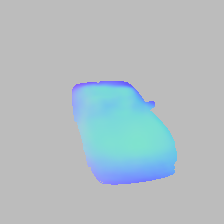

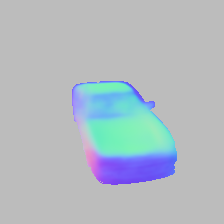

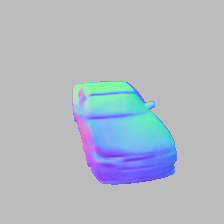

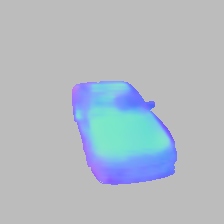

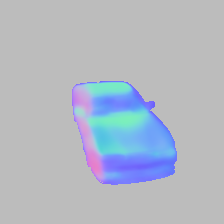

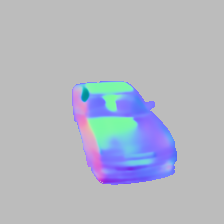

In [6]:
from IPython.display import Image, display
# In general, BN does better and larger input size does better.
display(Image(filename='results_BN_filtered/easy-00.png'))
display(Image(filename='results_resized_BN_filtered/easy-00.png'))
display(Image(filename='results_resized_extra_large_BN_filtered/easy-00.png'))
display(Image(filename='results_GN_filtered/easy-00.png'))
display(Image(filename='results_resized_GN_filtered/easy-00.png'))
display(Image(filename='results_resized_extra_large_GN_filtered/easy-00.png'))

In [7]:
# compare metrics of original vs large then resized images
import os
import torchvision
import torchmetrics
import numpy as np
import torch.nn as nn

true = "normal_1176dff7f0ec879719d740e0f6a9a113"
preds = ["results_BN_filtered", "results_resized_BN_filtered", "results_resized_extra_large_BN_filtered", "results_GN_filtered", "results_resized_GN_filtered", "results_resized_extra_large_GN_filtered"]
vif_fn = torchmetrics.image.VisualInformationFidelity(reduction='mean')
vifs = {}

for pred in preds:
    vifs[pred] = {"easy": [], "hard": []}
    if os.path.isdir(pred):
        for filename in os.listdir(pred):
            if filename.lower().endswith(".png"):
                if filename in os.listdir(true):
                    imghat = torchvision.io.read_image(os.path.join(pred, filename)) / 255
                    img = torchvision.io.read_image(os.path.join(true, filename)) / 255

                    imghat = imghat.unsqueeze(0)
                    img = img.unsqueeze(0)
                    vif = vif_fn(imghat, img)
                    if filename.lower().startswith("easy"):
                        difficulty = "easy"
                    else:
                        difficulty = "hard"
                    vifs[pred][difficulty].append(vif.item())
                
                else:
                    print(f"File {filename} in predicted folder has no match in true folder.")
    else:
        print(f"Predicted folder {pred} not found.")

for pred in vifs:
    for difficulty in vifs[pred]:
        avg_metric = np.mean(vifs[pred][difficulty])
        print(f"Average VIF for {difficulty} images with {pred}: {avg_metric:.8f}")
        std_metric = np.std(vifs[pred][difficulty])
        print(f"Standard Deviation of VIF for {difficulty} images with {pred}: {std_metric:.8f}")

Average VIF for easy images with results_BN_filtered: 0.40045922
Standard Deviation of VIF for easy images with results_BN_filtered: 0.08261306
Average VIF for hard images with results_BN_filtered: 0.40798120
Standard Deviation of VIF for hard images with results_BN_filtered: 0.09052165
Average VIF for easy images with results_resized_BN_filtered: 0.46340931
Standard Deviation of VIF for easy images with results_resized_BN_filtered: 0.08024080
Average VIF for hard images with results_resized_BN_filtered: 0.46591666
Standard Deviation of VIF for hard images with results_resized_BN_filtered: 0.09755563
Average VIF for easy images with results_resized_extra_large_BN_filtered: 0.54134549
Standard Deviation of VIF for easy images with results_resized_extra_large_BN_filtered: 0.11930185
Average VIF for hard images with results_resized_extra_large_BN_filtered: 0.52631363
Standard Deviation of VIF for hard images with results_resized_extra_large_BN_filtered: 0.12453499
Average VIF for easy ima

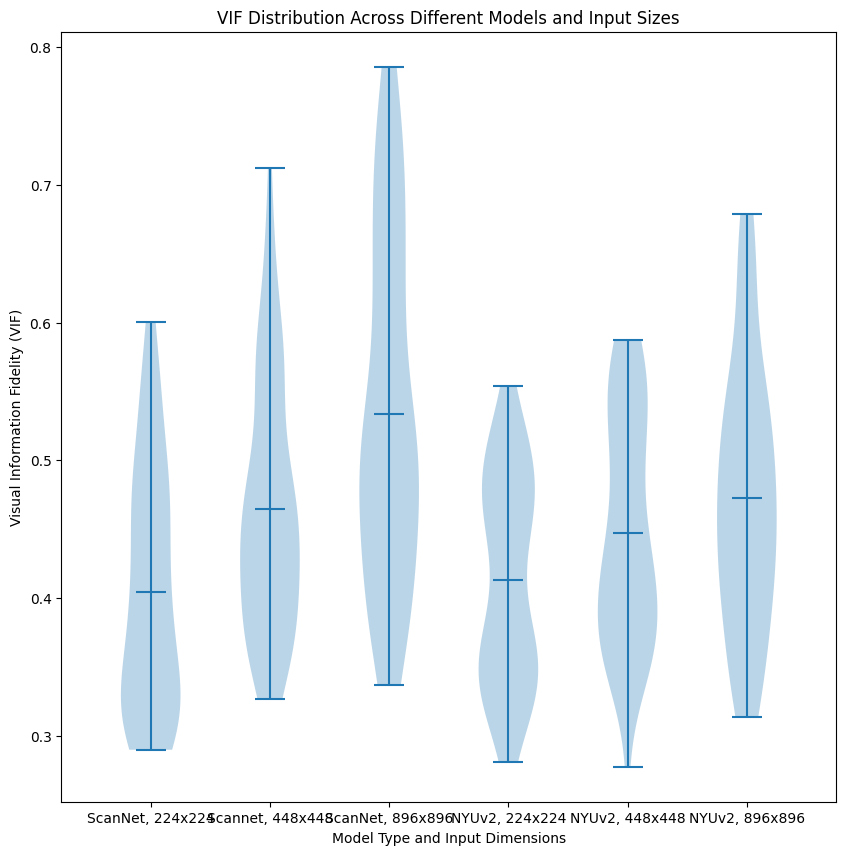

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
labels = [('results_BN_filtered', 'ScanNet, 224x224'), ('results_resized_BN_filtered', 'Scannet, 448x448'), 
          ('results_resized_extra_large_BN_filtered', 'ScanNet, 896x896'), ('results_GN_filtered', 'NYUv2, 224x224'), 
          ('results_resized_GN_filtered', 'NYUv2, 448x448'), ('results_resized_extra_large_GN_filtered', 'NYUv2, 896x896')]
plt.violinplot([vifs[pred]["easy"] + vifs[pred]["hard"] for (pred, _) in labels], showmeans=True)
word_labels = [lbl for (_, lbl) in labels]
ax.set_xticks(np.arange(1, len(word_labels) + 1), labels=word_labels)
ax.set_xlim(0.25, len(word_labels) + 0.75)
ax.set_ylabel('Visual Information Fidelity (VIF)')
ax.set_xlabel('Model Type and Input Dimensions')
ax.set_title('VIF Distribution Across Different Models and Input Sizes')
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()